# Figures B6 and B7: Sensitivity of regression estimates to lags

In [1]:
source('../scripts/load_libraries.R')
source('../scripts/load_constants.R')


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: Matrix


Attaching package: ‘tidyr’


The following objects are masked from ‘package:Matrix’:

    expand, pack, unpack



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union



Please cite as: 


 Hlavac, Marek (2018). stargazer: Well-Formatted Regression and Summary Statistics Tables.

 R package version 5.2.2. https://CRAN.R-project.org/package=stargazer 



Attaching package: ‘lemon’


The following objects are masked from ‘package:ggplot2’:

    CoordCartesian, element_render




In [2]:
source('../scripts/load_data.R')

Rows: 17264341 Columns: 5
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
dbl (5): comment_id, user_id, author_id, anonymous, first_view

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1281001 Columns: 4
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
dbl (4): comment_id, user_id, score, time_stamp

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 223737 Columns: 4
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
dbl (4): comment_id, user_id, num, time_stamp

ℹ Use `spec()` t

This is annoying but running >1 time tends to cause memory allocation errors. So we'll run this cell four times and then plot in the next step. I know I know.

In [3]:
the_lag <- 28
source('../scripts/load_moderator_variables.R')

m1_up <- feglm(I(100 * up) ~ identified * (scale(production) + scale(reputation))| user_id + author_id, se = "twoway", 
               data = df_with_covariates,
               mem.clean = TRUE,
               family='gaussian')
m1_dn <- feglm(I(100 * dn) ~ identified * (scale(production) + scale(reputation))| user_id + author_id, se = "twoway", 
               data = df_with_covariates,
               mem.clean = TRUE,
               family='gaussian')
m1_rp <- feglm(I(100 * rp) ~ identified * (scale(production) + scale(reputation))| user_id + author_id, se = "twoway", 
               data = df_with_covariates,
               mem.clean = TRUE,
               family='gaussian')

bind_rows(
    broom::tidy(m1_up) %>% mutate(outcome = 'Up-vote'),
    broom::tidy(m1_dn) %>% mutate(outcome = 'Down-vote'),
    broom::tidy(m1_rp) %>% mutate(outcome = 'Reply'),
) %>% 
  mutate(lag = the_lag) %>%
  write_csv('../estimates/m1_lag{the_lag}.csv' %>% glue::glue())

for_pairwise_model <- df_with_covariates %>%
    mutate(ri = reciprocity * identified, 
           pair = paste(user_id, author_id, sep = '_')) %>%
    filter(!is.na(reciprocity))

m2_up <- feglm(I(100 * up) ~ reciprocity + ri | pair, se = "cluster", 
               data = for_pairwise_model, 
               mem.clean = TRUE,
               family='gaussian')
m2_dn <- feglm(I(100 * dn) ~ reciprocity + ri | pair, se = "cluster", 
               data = for_pairwise_model, 
               mem.clean = TRUE,
               family='gaussian')
m2_rp <- feglm(I(100 * rp) ~ reciprocity + ri | pair, se = "cluster", 
               data = for_pairwise_model, 
               mem.clean = TRUE,
               family='gaussian')

bind_rows(
    broom::tidy(m2_up) %>% mutate(outcome = 'Up-vote'),
    broom::tidy(m2_dn) %>% mutate(outcome = 'Down-vote'),
    broom::tidy(m2_rp) %>% mutate(outcome = 'Reply'),
) %>% 
  mutate(lag = the_lag) %>%
  write_csv('../estimates/m2_lag{the_lag}.csv' %>% glue::glue())


Using the_lag=28

`summarise()` has grouped output by 'author_id'. You can override using the `.groups` argument.
Joining, by = c("author_id", "ds")
Joining, by = c("author_id", "ds")
Joining, by = c("user_id", "author_id", "ds")
NOTE: 602,304 observations removed because of NA values (RHS: 602,304).

NOTE: 602,304 observations removed because of NA values (RHS: 602,304).

NOTE: 602,304 observations removed because of NA values (RHS: 602,304).



Rows: 15 Columns: 7
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (2): term, outcome
dbl (5): estimate, std.error, statistic, p.value, lag

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 15 Columns: 7
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (2): term, outcome
dbl (5): estimate, std.error, statistic, p.value, lag

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 15 Columns: 7
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (2): term, outcome
dbl (5): est

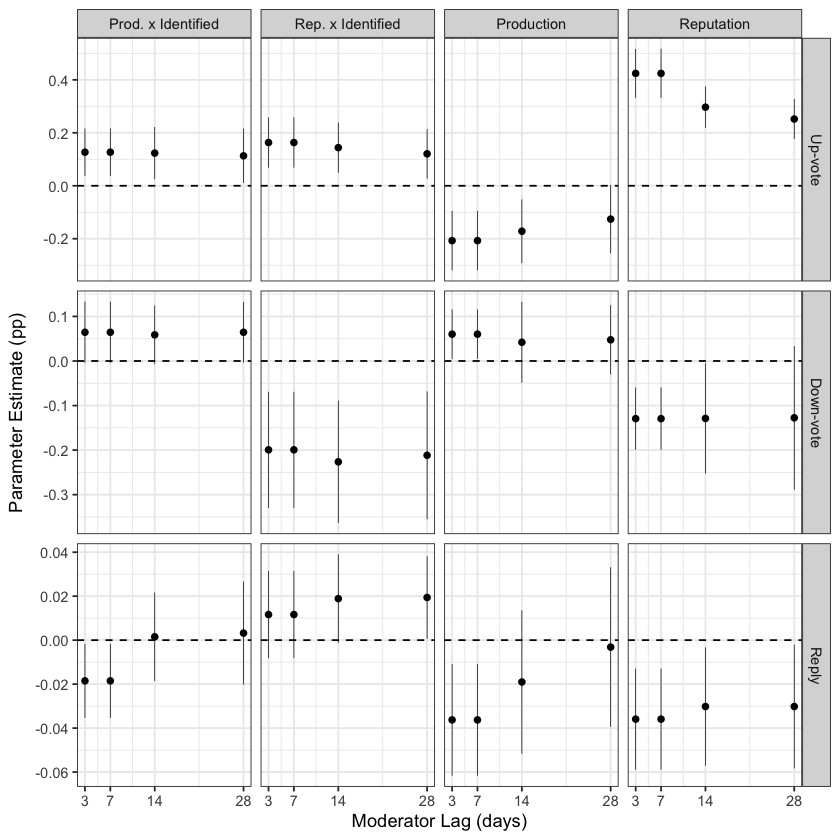

In [27]:
p1 <- list.files(path = "../estimates/", pattern = "m1_lag\\d+.csv") %>%
  purrr::map_df(~read_csv(paste("../estimates/", ., sep = ''))) %>%
  filter(term != 'identified') %>%
  mutate(outcome = factor(outcome, levels = outcome.levels)) %>%
  mutate(term = forcats::fct_recode(factor(term),
                                    `Production` = 'scale(production)', 
                                    `Prod. x Identified` = 'identified:scale(production)', 
                                    `Reputation` = 'scale(reputation)', 
                                    `Rep. x Identified` = 'identified:scale(reputation)')) %>%
  ggplot(aes(x = lag, y = estimate,
             ymin = (estimate - 1.96 * std.error),
             ymax = (estimate + 1.96 * std.error))) +
  geom_pointrange(size = .2) +
  geom_hline(yintercept = 0.0, linetype = 'dashed') +
  scale_x_continuous(breaks = c(3,7,14,28)) +
  facet_grid(outcome ~ term, scales = 'free_y') +
  xlab('Moderator Lag (days)') +
  ylab('Parameter Estimate (pp)') +
  theme_bw()
p1

In [28]:
ggsave('../figures/fig-b6.pdf', p1, width = 6, height = 6)

Rows: 6 Columns: 7
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (2): term, outcome
dbl (5): estimate, std.error, statistic, p.value, lag

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 6 Columns: 7
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (2): term, outcome
dbl (5): estimate, std.error, statistic, p.value, lag

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 6 Columns: 7
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (2): term, outcome
dbl (5): estima

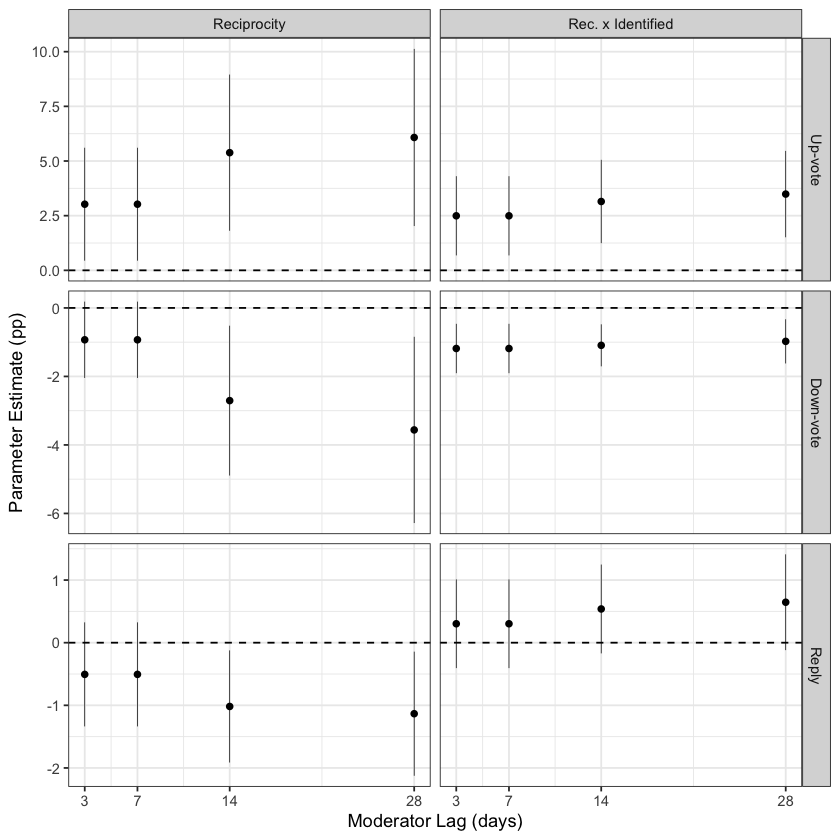

In [30]:
p2 <- list.files(path = "../estimates/", pattern = "m2_lag\\d+.csv") %>%
  purrr::map_df(~read_csv(paste("../estimates/", ., sep = ''))) %>%
  filter(term != 'identified') %>%
  mutate(outcome = factor(outcome, levels = outcome.levels)) %>%
  mutate(term = forcats::fct_recode(factor(term),
                                    `Reciprocity` = 'reciprocity', 
                                    `Rec. x Identified` = 'ri')) %>%
  ggplot(aes(x = lag, y = estimate,
             ymin = (estimate - 1.96 * std.error),
             ymax = (estimate + 1.96 * std.error))) +
  geom_pointrange(size = .2) +
  geom_hline(yintercept = 0.0, linetype = 'dashed') +
  scale_x_continuous(breaks = c(3,7,14,28)) +
  facet_grid(outcome ~ term, scales = 'free_y') +
  xlab('Moderator Lag (days)') +
  ylab('Parameter Estimate (pp)') +
  theme_bw()
p2

In [31]:
ggsave('../figures/fig-b7.pdf', p2, width = 6, height = 6)